In [1]:
from specutils import Spectrum, SpectralRegion
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.modeling import models
from astropy.modeling.fitting import TRFLSQFitter
from astropy.convolution import Box1DKernel

from specutils.fitting import fit_lines
from specutils.manipulation import extract_region, box_smooth, median_smooth
from specutils.manipulation import gaussian_smooth, trapezoid_smooth, convolution_smooth
from specutils.fitting import estimate_line_parameters
from specutils.utils.wcs_utils import air_to_vac


In [2]:
spec1 = fits.open('fits/FBS0022-021/ADP.2021-02-01T09_48_13.681.fits')#
spec2 = fits.open('fits/FBS0022-021/ADP.2021-02-01T09_55_45.877.fits')
spec3 = fits.open('fits/FBS0022-021/ADP.2021-02-01T09_57_01.820.fits')#
spec4 = fits.open('fits/FBS0022-021/ADP.2021-02-01T09_57_01.824.fits')

#Average good spectra above
#In order to average will need to interpolate

spectra = [spec1,spec2,spec3,spec4]



print(spec1[0].header['SNR']) #2020-11-05 01:39:40

print(spec3[0].header['SNR']) #2020-11-10 01:27:49


for i in range(len(spectra)):
    wavelength = spectra[i][1].data[0][0]*u.AA
    flux = spectra[i][1].data[0][1]  * u.erg * u.cm**(-2) * u.s**(-1) * u.AA**(-1) #* 10e-16
    spectra[i] = Spectrum(spectral_axis=wavelength, flux=flux)

43.9661
44.7403


Text(0, 0.5, 'Flux')

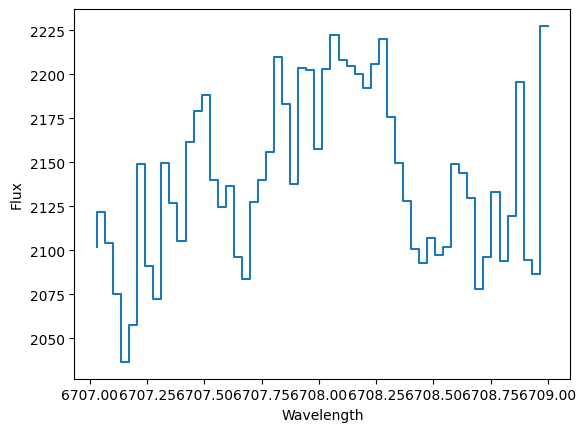

In [3]:

fig, ax = plt.subplots(1)

spec1d = spectra[0]

sub_region = SpectralRegion(6707*u.AA,6709*u.AA)
sub_spec = extract_region(spec1d, sub_region)



ax.step(sub_spec.spectral_axis, sub_spec.flux)

ax.set_xlabel("Wavelength")

ax.set_ylabel("Flux")




In [4]:
spec1d = Spectrum(spectral_axis=wavelength, flux=flux)


def gaussianfitter(spectrum,lambmin,lambmax, title='Plot', excluderegion=None, fit=True):
    sub_region = SpectralRegion(lambmin*u.AA,lambmax*u.AA)
    sub_spec = extract_region(spectrum, sub_region)
    
    
        
    ax = plt.subplots()[1]
    
    ax.scatter(sub_spec.spectral_axis, sub_spec.flux,marker='+',color='black')
    ax.plot(sub_spec.spectral_axis, sub_spec.flux,linestyle='dashed',color='silver')

    ax.set_xlabel("Wavelength")

    ax.set_ylabel("Flux")
    ax.set_title(title)
    if fit:
        result = estimate_line_parameters(sub_spec, models.Gaussian1D())
        print('----------------------')
        print(title)
        print(result.amplitude)

        print(result.mean)

        print(result.stddev)
        print('----------------------')

        g_init = models.Gaussian1D(amplitude=result.amplitude, mean=result.mean, stddev=result.stddev)
    
        if excluderegion != None:
            g_fit = fit_lines(sub_spec, g_init, 
                      exclude_regions=[SpectralRegion(excluderegion[0]*u.AA, excluderegion[1]*u.AA)])
        else:
            g_fit = fit_lines(sub_spec, g_init)
        
    
        y_fit = g_fit(sub_spec.spectral_axis)

        plt.plot(sub_spec.spectral_axis, y_fit,color='red')
        return result.mean, result.stddev
    return ax



    

# Radial Velocity Corrections and Position of Li I Line

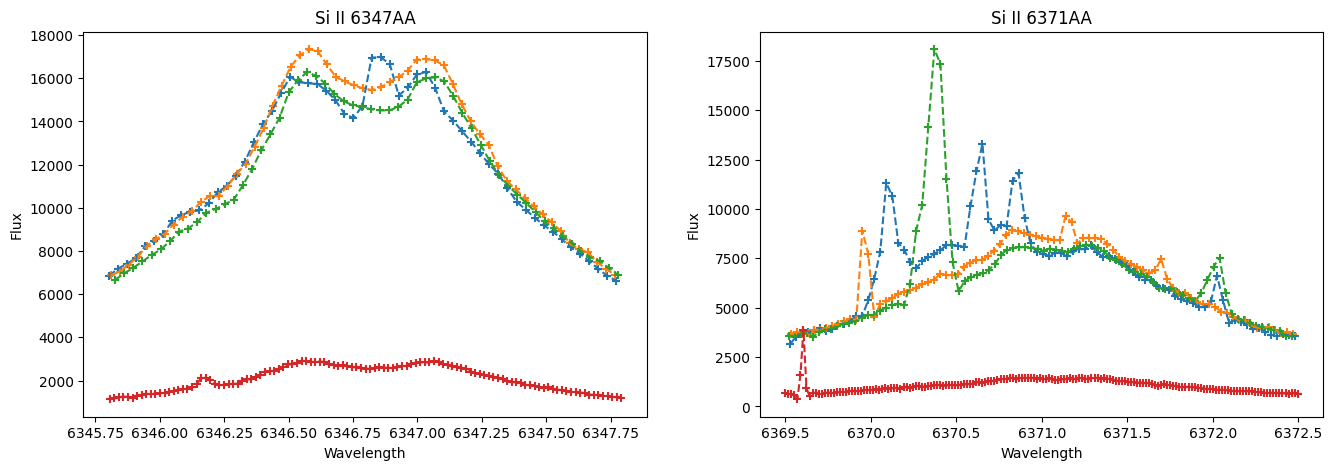

In [5]:
fig, ax = plt.subplots(1,2, figsize=(16,5))


for spec in spectra:
    sub_region = SpectralRegion(6345.8*u.AA,6347.8*u.AA)
    sub_spec = extract_region(spec, sub_region)
    

    ax[0].scatter(sub_spec.spectral_axis, sub_spec.flux,marker='+')
    ax[0].plot(sub_spec.spectral_axis, sub_spec.flux,linestyle='dashed')

    ax[0].set_xlabel("Wavelength")

    ax[0].set_ylabel("Flux")
    ax[0].set_title("Si II 6347AA")

for spec in spectra:
    sub_region = SpectralRegion(6369.5*u.AA,6372.5*u.AA)
    sub_spec = extract_region(spec, sub_region)
    

    ax[1].scatter(sub_spec.spectral_axis, sub_spec.flux,marker='+')
    ax[1].plot(sub_spec.spectral_axis, sub_spec.flux,linestyle='dashed')

    ax[1].set_xlabel("Wavelength")

    ax[1].set_ylabel("Flux")
    ax[1].set_title("Si II 6371AA")



Spectrum  1
----------------------
Si II 6347AA
Parameter('amplitude', value=16973.888671875, unit=erg / (Angstrom s cm2))
Parameter('mean', value=6346.784601621019, unit=Angstrom)
Parameter('stddev', value=0.5058016388490691, unit=Angstrom, bounds=(1.1754943508222875e-38, None))
----------------------
Difference in AA =  -0.3253983789809354 Angstrom AA
Radial Velocity =  [<Quantity -15380.15154839>] m/s
----------------------
Si II 6371AA
Parameter('amplitude', value=13297.5224609375, unit=erg / (Angstrom s cm2))
Parameter('mean', value=6370.972861740366, unit=Angstrom)
Parameter('stddev', value=0.7254280682515754, unit=Angstrom, bounds=(1.1754943508222875e-38, None))
----------------------
Difference in AA =  -0.38713825963350246 Angstrom AA
Radial Velocity =  [<Quantity -18228.67926001>] m/s
Spectrum  2
----------------------
Si II 6347AA
Parameter('amplitude', value=17347.814453125, unit=erg / (Angstrom s cm2))
Parameter('mean', value=6346.79419492135, unit=Angstrom)
Parameter('std

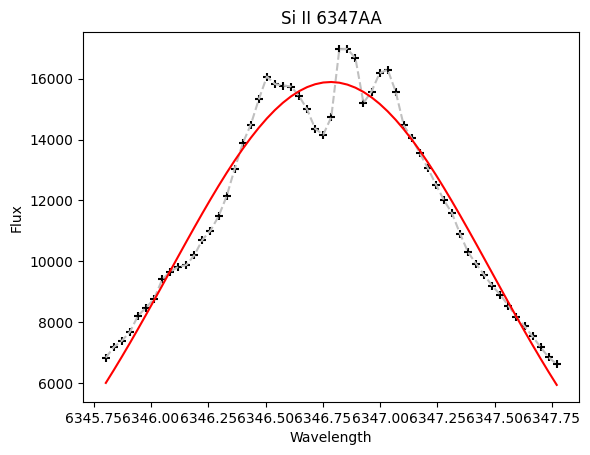

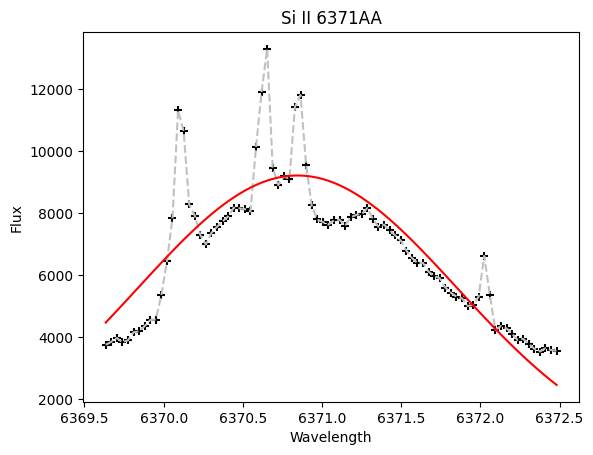

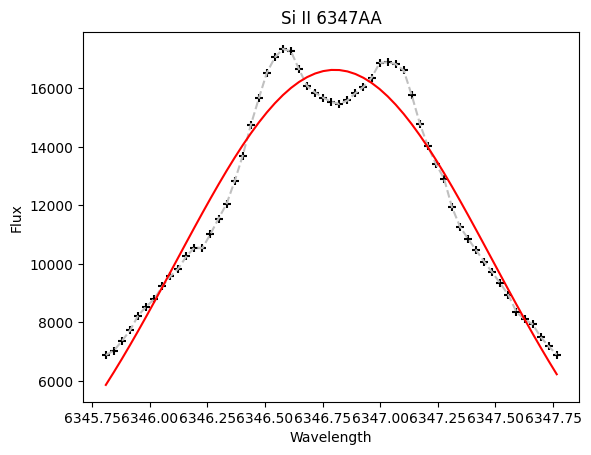

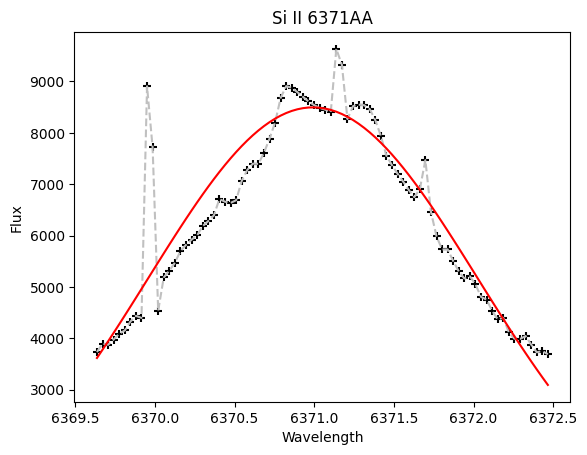

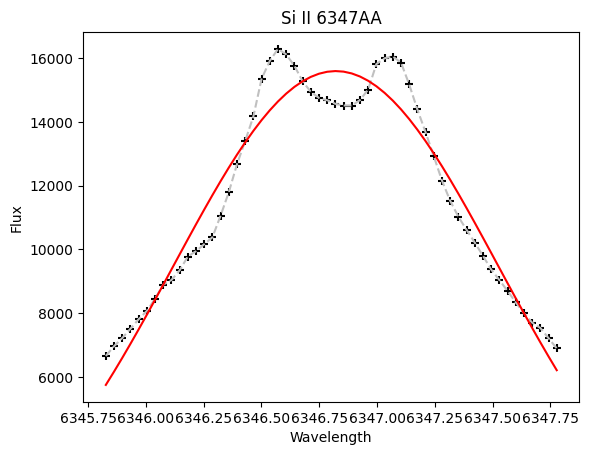

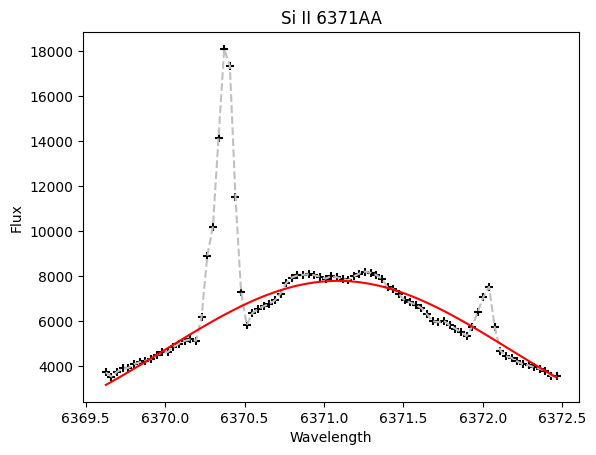

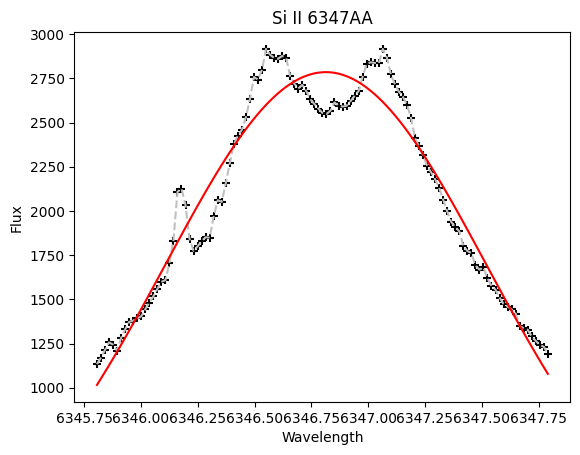

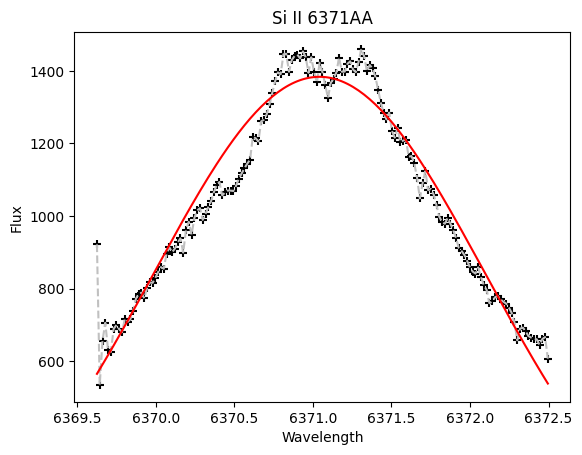

In [6]:
#Estimating radial velocity

lamb1 = 6347.11*u.AA
lamb2 = 6371.36*u.AA

vel1 = []
vel2 = []
for i in range(len(spectra)):
    print('============================================')
    print('Spectrum ',i+1)
    mean6347 = gaussianfitter(spectra[i],6345.8,6347.8,title='Si II 6347AA',
                              #excluderegion=[6346.55,6346.9]
                             )
    #6347.11
    print('Difference in AA = ',mean6347[0].value*u.AA - lamb1,'AA')
    vel1.append(3e8*(mean6347[0].value*u.AA - lamb1) / lamb1)
    print('Radial Velocity = ', vel1, 'm/s')


    
    mean6371 = gaussianfitter(spectra[i],6369.61,6372.5,title='Si II 6371AA',
                              excluderegion=[6370.2,6370.5]
                             )
    #6371.36
    print('Difference in AA = ',mean6371[0].value*u.AA- lamb2,'AA')
    vel2.append(3e8*(mean6371[0].value*u.AA - lamb2) / lamb2)
    print('Radial Velocity = ', vel2, 'm/s')



$v = c\frac{\Delta\lambda}{\lambda_0}$

In [7]:
pos1 = []
pos2 = []
for i in range(len(vel1)):
    print('===============================================')
    print('Spectrum ',i+1)
    pos1.append(6707.76 + vel1[i]/(3e8/6707.76))
    pos2.append(6707.76 + vel2[i]/(3e8/6707.76))
    print('Line position for Li I line from velocity correction for Si II 6347AA: \n',
      pos1[i])
    print('Line position for Li I line from velocity correction for Si II 6371AA: \n',
      pos2[i])

Spectrum  1
Line position for Li I line from velocity correction for Si II 6347AA: 
 6707.416112115499
Line position for Li I line from velocity correction for Si II 6371AA: 
 6707.35242131469
Spectrum  2
Line position for Li I line from velocity correction for Si II 6347AA: 
 6707.426250518053
Line position for Li I line from velocity correction for Si II 6371AA: 
 6707.411758580041
Spectrum  3
Line position for Li I line from velocity correction for Si II 6347AA: 
 6707.44427986742
Line position for Li I line from velocity correction for Si II 6371AA: 
 6707.386934081062
Spectrum  4
Line position for Li I line from velocity correction for Si II 6347AA: 
 6707.438562707762
Line position for Li I line from velocity correction for Si II 6371AA: 
 6707.4399679136


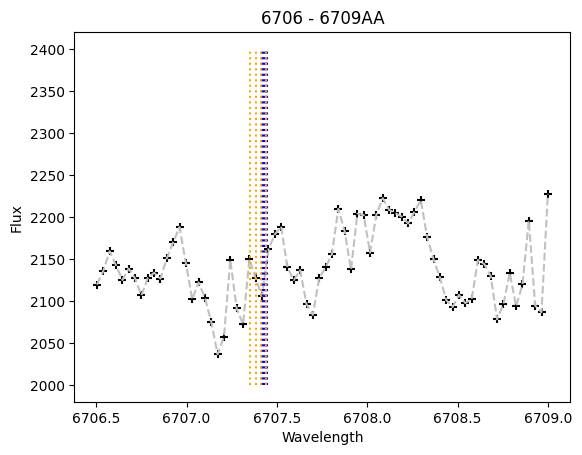

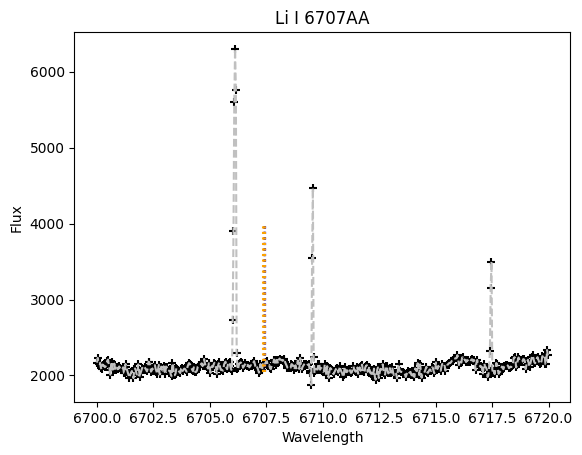

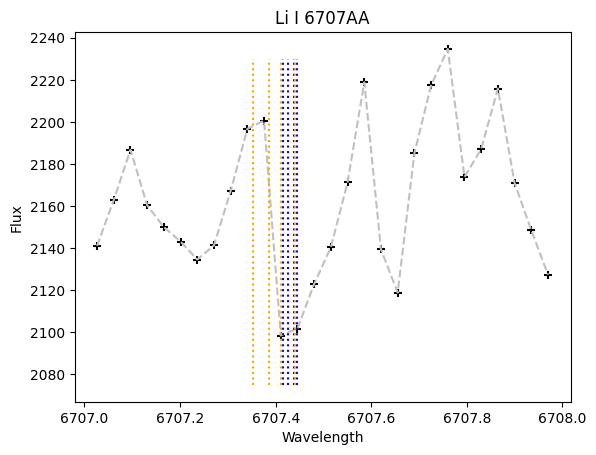

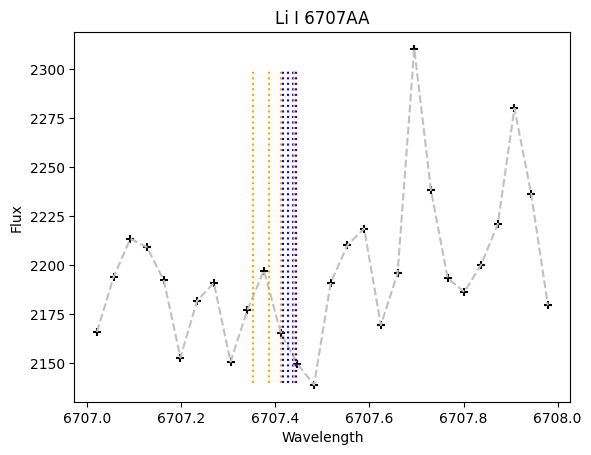

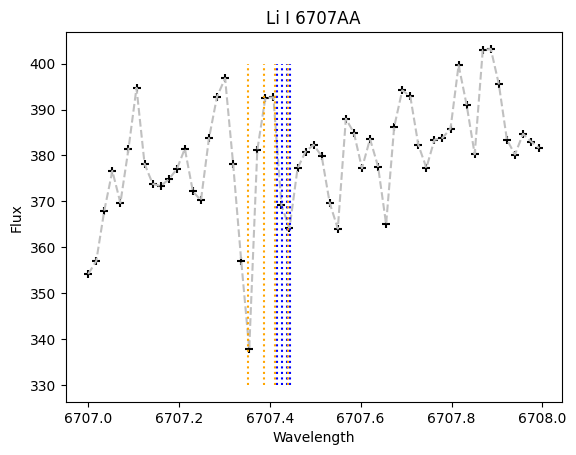

In [8]:
#6707,6708
mean6371 = gaussianfitter(spectra[0],6706.5,6709,title='6706 - 6709AA',fit=False)

for i in range(len(pos1)):
    
    mean6371.plot(pos1[i]*np.ones(100),np.linspace(2000,2400,100),linestyle='dotted',color='blue',alpha=1)
    mean6371.plot(pos2[i]*np.ones(100),np.linspace(2000,2400,100),linestyle='dotted',color='orange',alpha=1)



mean6371 = gaussianfitter(spectra[0],6700,6720,title='Li I 6707AA',fit=False)

for i in range(len(pos1)):
    
    mean6371.plot(pos1[i]*np.ones(100),np.linspace(2040,4000,100),linestyle='dotted',color='blue',alpha=1)
    mean6371.plot(pos2[i]*np.ones(100),np.linspace(2040,4000,100),linestyle='dotted',color='orange',alpha=1)


mean6371 = gaussianfitter(spectra[1],6707,6708,title='Li I 6707AA',fit=False)



for i in range(len(pos1)):
    
    mean6371.plot(pos1[i]*np.ones(100),np.linspace(2075,2230,100),linestyle='dotted',color='blue',alpha=1)
    mean6371.plot(pos2[i]*np.ones(100),np.linspace(2075,2230,100),linestyle='dotted',color='orange',alpha=1)


mean6371 = gaussianfitter(spectra[2],6707,6708,title='Li I 6707AA',fit=False)



for i in range(len(pos1)):
    
    mean6371.plot(pos1[i]*np.ones(100),np.linspace(2140,2300,100),linestyle='dotted',color='blue',alpha=1)
    mean6371.plot(pos2[i]*np.ones(100),np.linspace(2140,2300,100),linestyle='dotted',color='orange',alpha=1)


mean6371 = gaussianfitter(spectra[3],6707,6708,title='Li I 6707AA',fit=False)



for i in range(len(pos1)):
    
    mean6371.plot(pos1[i]*np.ones(100),np.linspace(330,400,100),linestyle='dotted',color='blue',alpha=1)
    mean6371.plot(pos2[i]*np.ones(100),np.linspace(330,400,100),linestyle='dotted',color='orange',alpha=1)

#### Blue - line centre prediction from Si II 6347 AA radial velocity correction
#### Orange - line centre prediction from Si II 6371 AA radial velocity correction

# Rumenskikh Method

#### Na D1: $J_g=1/2$, $J_e=3/2$ -> Statweight $\sim 0.6$
#### Na D2: $J_g=1/2$, $J_e=1/2$ -> Statweight $\sim 0.2$



<Axes: title={'center': 'H alpha'}, xlabel='Wavelength', ylabel='Flux'>

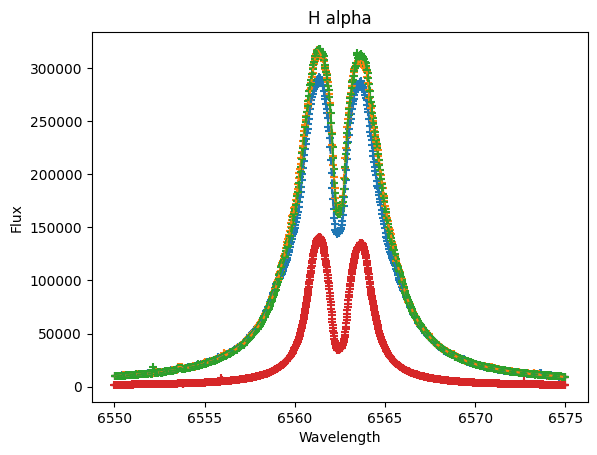

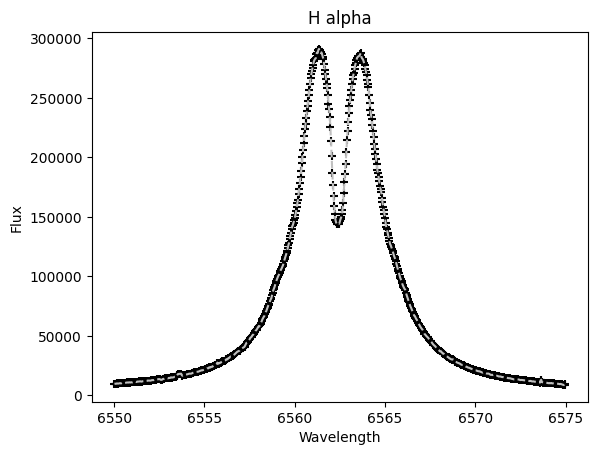

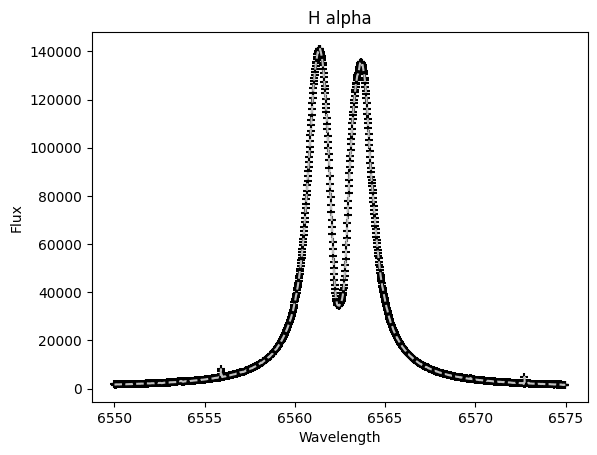

In [9]:
#Checking Halpha line profile

ax = plt.subplots()[1]


for spec in spectra:
    sub_region = SpectralRegion(6550*u.AA,6575*u.AA)
    sub_spec = extract_region(spec, sub_region)
    

    ax.scatter(sub_spec.spectral_axis, sub_spec.flux,marker='+')
    ax.plot(sub_spec.spectral_axis, sub_spec.flux,linestyle='dashed')

    ax.set_xlabel("Wavelength")

    ax.set_ylabel("Flux")
    ax.set_title("H alpha")

gaussianfitter(spectra[0], 6550,6575, title='H alpha',fit=False)
gaussianfitter(spectra[3], 6550,6575, title='H alpha',fit=False)

In [10]:
def gaussianfitterdouble(spectrum,lambmin,lambmax,gaussparams, 
                         title='Plot'):
    sub_region = SpectralRegion(lambmin*u.AA,lambmax*u.AA)
    sub_spec = extract_region(spectrum, sub_region)
    if len(gaussparams) % 3 != 0:
        raise ValueError('Each Gaussian fit needs 3 values- amplitude, mean, stddev')
    
    
        
    ax = plt.subplots()[1]

    ax.scatter(sub_spec.spectral_axis, sub_spec.flux,marker='+',color='black')
    ax.plot(sub_spec.spectral_axis, sub_spec.flux,linestyle='dashed',color='silver')

    ax.set_xlabel("Wavelength")

    ax.set_ylabel("Flux")
    ax.set_title(title)
    g_init = models.Gaussian1D(amplitude=gaussparams[0]*u.erg * u.cm**(-2) * u.s**(-1) * u.AA**(-1),
                               mean=gaussparams[1]*u.AA,
                               stddev=gaussparams[2]*u.AA)
    
    if len(gaussparams) > 3:
        for i in range(int(len(gaussparams)/3)):
        

            g_init += models.Gaussian1D(amplitude=gaussparams[i]*u.erg * u.cm**(-2) * u.s**(-1) * u.AA**(-1),
                                        mean=gaussparams[i+1]*u.AA,
                                        stddev=gaussparams[i+2]*u.AA)
    print(g_init)
        
        
    g_fit = fit_lines(sub_spec,g_init)
    y_fit = g_fit(sub_spec.spectral_axis)

    plt.plot(sub_spec.spectral_axis, y_fit,color='red')
        
    return ax

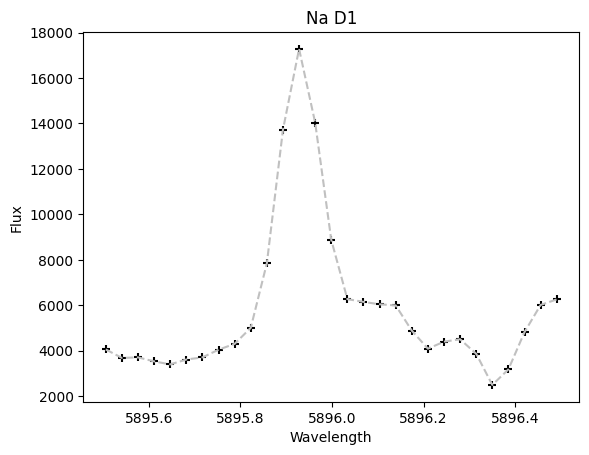

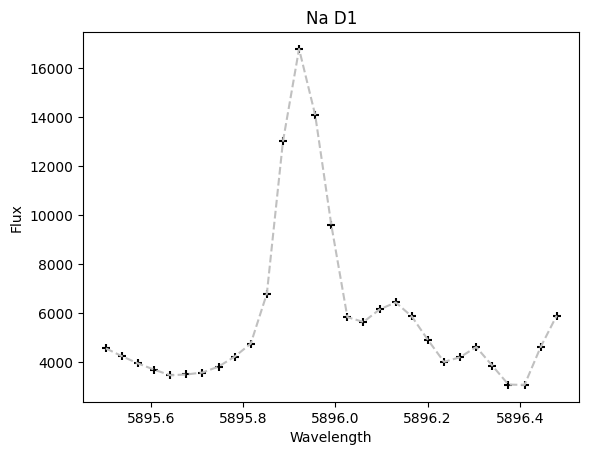

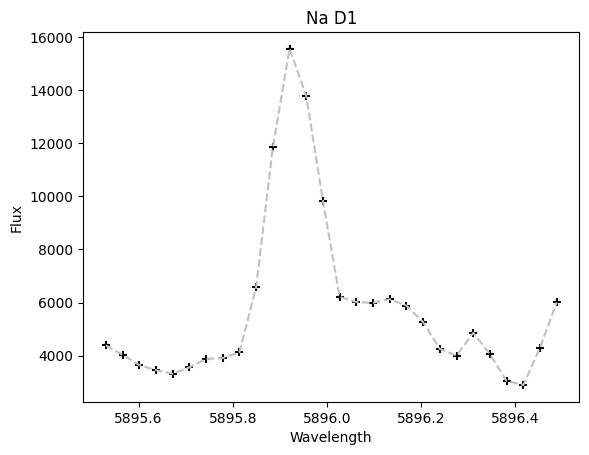

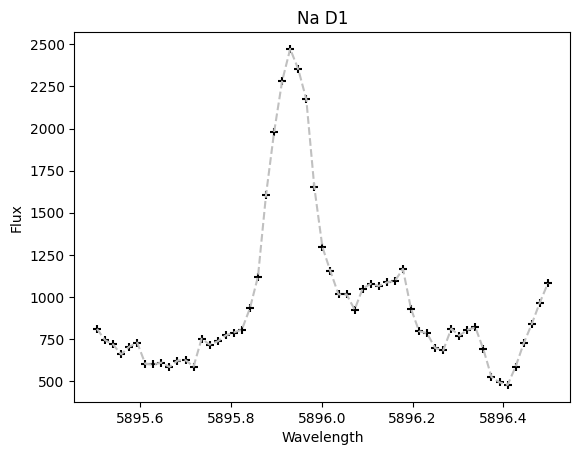

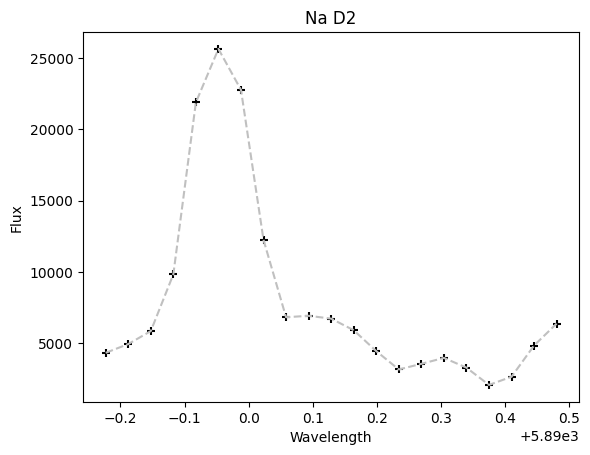

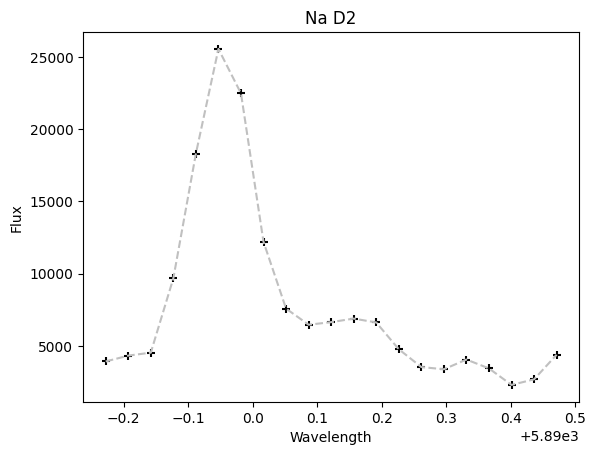

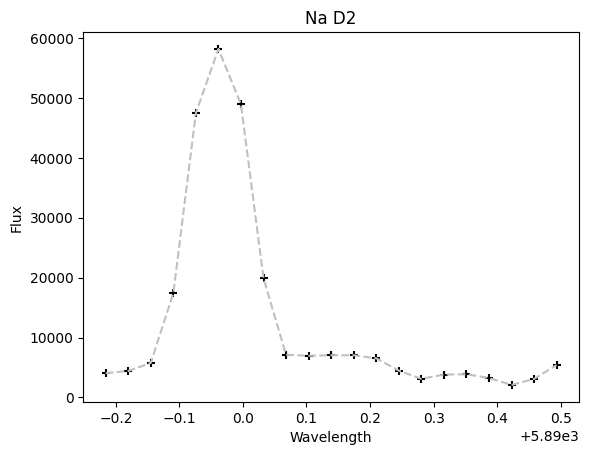

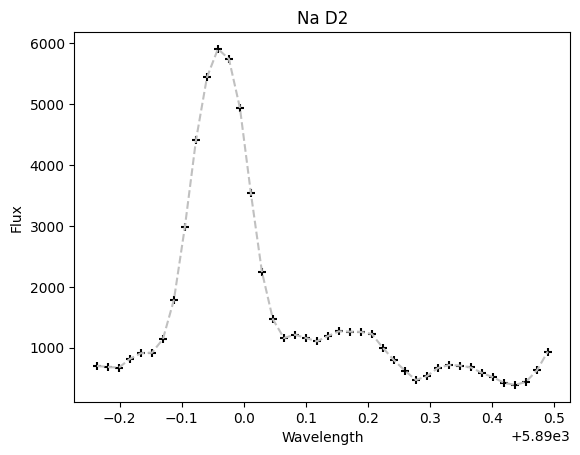

In [11]:
# D1 = 5895.92424
# D2 = 5889.95095

ax1 = gaussianfitter(spectra[0], 5895.5,5896.5, title='Na D1',fit=False)
#ax1 = gaussianfitterdouble(spectra[0], 5895.5,5896.5, [17500,5895.7,0.2], title='Na D1')


#ax1.plot()
ax2 = gaussianfitter(spectra[1], 5895.5,5896.5, title='Na D1',fit=False)
ax3 = gaussianfitter(spectra[2], 5895.5,5896.5, title='Na D1',fit=False)
ax4 = gaussianfitter(spectra[3], 5895.5,5896.5, title='Na D1',fit=False)

ax5 = gaussianfitter(spectra[0], 5889.75,5890.5, title='Na D2',fit=False)
ax6 = gaussianfitter(spectra[1], 5889.75,5890.5, title='Na D2',fit=False)
ax7 = gaussianfitter(spectra[2], 5889.75,5890.5, title='Na D2',fit=False)
ax8 = gaussianfitter(spectra[3], 5889.75,5890.5, title='Na D2',fit=False)


# Averaging Two Spectral Epochs

In [12]:
from astropy.visualization import quantity_support

quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x740401652f60>

In [13]:

sub_region1 = SpectralRegion(5750*u.AA,7500*u.AA)
sub_region2 = SpectralRegion(7750*u.AA,9500*u.AA)
    


spec1 = [extract_region(spectra[0], sub_region1),extract_region(spectra[0], sub_region2)]
spec2 = [extract_region(spectra[2], sub_region1),extract_region(spectra[2], sub_region2)]

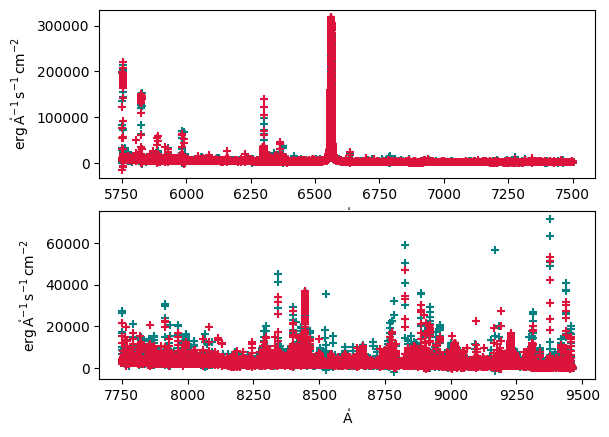

In [14]:
fig, ax = plt.subplots(2)

ax[0].scatter(spec1[0].spectral_axis,spec1[0].flux, marker='+',color='teal')
ax[0].scatter(spec2[0].spectral_axis,spec2[0].flux, marker='+',color='crimson')

ax[1].scatter(spec1[1].spectral_axis,spec1[1].flux, marker='+',color='teal')
ax[1].scatter(spec2[1].spectral_axis,spec2[1].flux, marker='+',color='crimson')


#plt.ylim(-1000,2500)

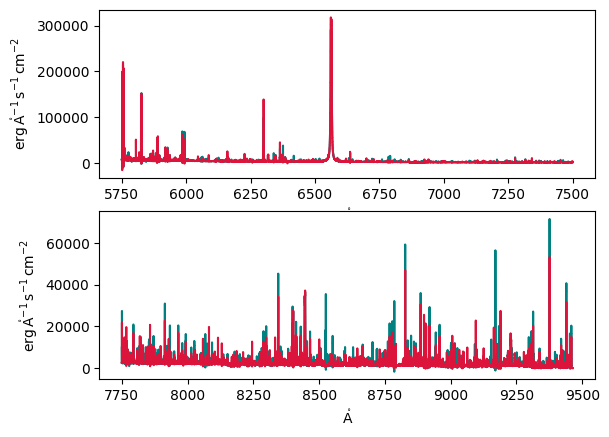

In [15]:
fig, ax = plt.subplots(2)

ax[0].step(spec1[0].spectral_axis,spec1[0].flux,color='teal')
ax[0].step(spec2[0].spectral_axis,spec2[0].flux,color='crimson')

ax[1].step(spec1[1].spectral_axis,spec1[1].flux,color='teal')
ax[1].step(spec2[1].spectral_axis,spec2[1].flux,color='crimson')




In [16]:
from specutils.manipulation import LinearInterpolatedResampler, FluxConservingResampler
from specutils.manipulation import SplineInterpolatedResampler

new_dispersion = spec1[0].spectral_axis
print(new_dispersion)
resampler = FluxConservingResampler()

spec2_resampled = resampler(spec2[0], new_dispersion)
print(spec2_resampled.shape)

[5750.02380985 5750.05895905 5750.09410826 ... 7499.92713692 7499.96228613
 7499.99743534] Angstrom
(49788,)


In [17]:
new_dispersion = spec2[0].spectral_axis
resampler = FluxConservingResampler()

spec1_resampled = resampler(spec1[0], new_dispersion)
print(spec1_resampled.shape)

(49337,)


(1800.0, 2900.0)

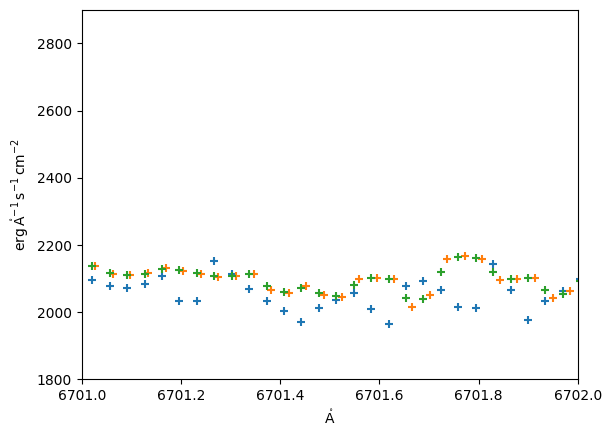

In [28]:
plt.scatter(spec1[0].spectral_axis,spec1[0].flux, marker='+')
#plt.scatter(spec2[0].spectral_axis,spec2[0].flux, marker='+')
plt.scatter(spec2[0].spectral_axis,spec2[0].flux, marker='+')



plt.scatter(spec2_resampled.spectral_axis,spec2_resampled.flux, marker='+')
plt.xlim(6701,6702)
plt.ylim(1800,2900)

(1800.0, 2900.0)

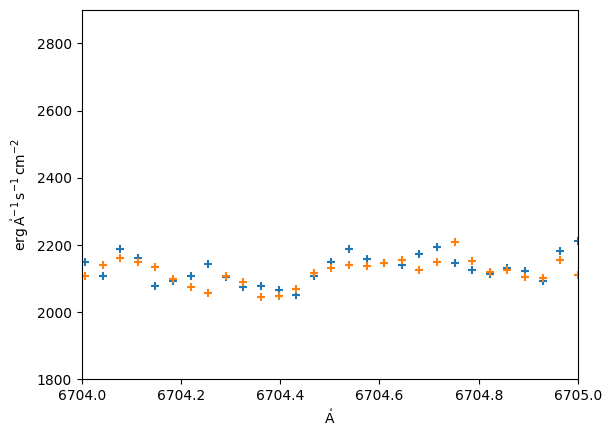

In [19]:
#plt.scatter(spec1[0].spectral_axis,spec1[0].flux, marker='+')
plt.scatter(spec2[0].spectral_axis,spec2[0].flux, marker='+')

plt.scatter(spec1_resampled.spectral_axis,spec1_resampled.flux, marker='+')
plt.xlim(6704,6705)
plt.ylim(1800,2900)

(5753.0, 5755.0)

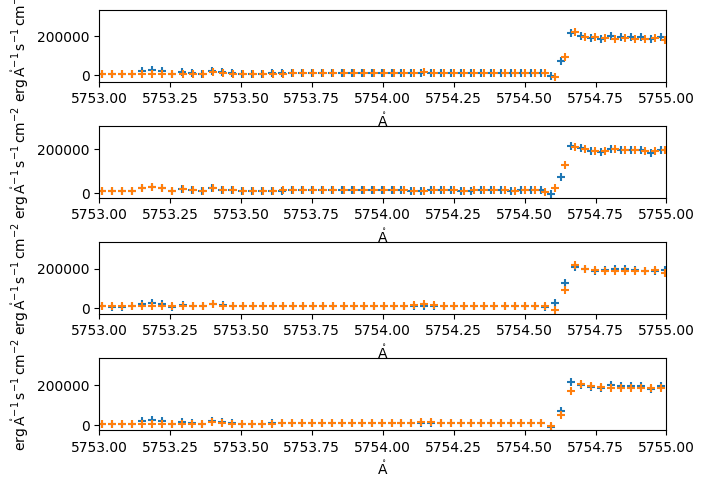

In [20]:
fig, ax = plt.subplots(4)
fig.tight_layout()
ax[0].scatter(spec1[0].spectral_axis,spec1[0].flux, marker='+')
ax[0].scatter(spec2[0].spectral_axis,spec2[0].flux, marker='+')
ax[0].set_xlim(5753,5755)

ax[1].scatter(spec1[0].spectral_axis,spec1[0].flux, marker='+')
ax[1].scatter(spec1_resampled.spectral_axis,spec1_resampled.flux, marker='+')
ax[1].set_xlim(5753,5755)


ax[2].scatter(spec1_resampled.spectral_axis,spec1_resampled.flux, marker='+')
ax[2].scatter(spec2[0].spectral_axis,spec2[0].flux, marker='+')
ax[2].set_xlim(5753,5755)



ax[3].scatter(spec1[0].spectral_axis,spec1[0].flux, marker='+')
ax[3].scatter(spec2_resampled.spectral_axis,spec2_resampled.flux, marker='+')
ax[3].set_xlim(5753,5755)


In [21]:

#plt.ylim(1800,2900)
wavsep = []
for i in range(len(spec2[0].spectral_axis)):
    wavsep.append((spec2[0].spectral_axis[i] - spec1_resampled.spectral_axis[i]))

for i in range(len(wavsep)):
    if np.sqrt(wavsep[i]**2) < 0.000001 * u.AA:
        #print(spec2[0].spectral_axis[i],' --- ',wavsep[i])
        pass

Smoothed Spectrum Shapes
------------------------
Original:   (49788,)
Box:        (49788,)
Gaussian:   (49788,)
Trapezoid:  (49788,)


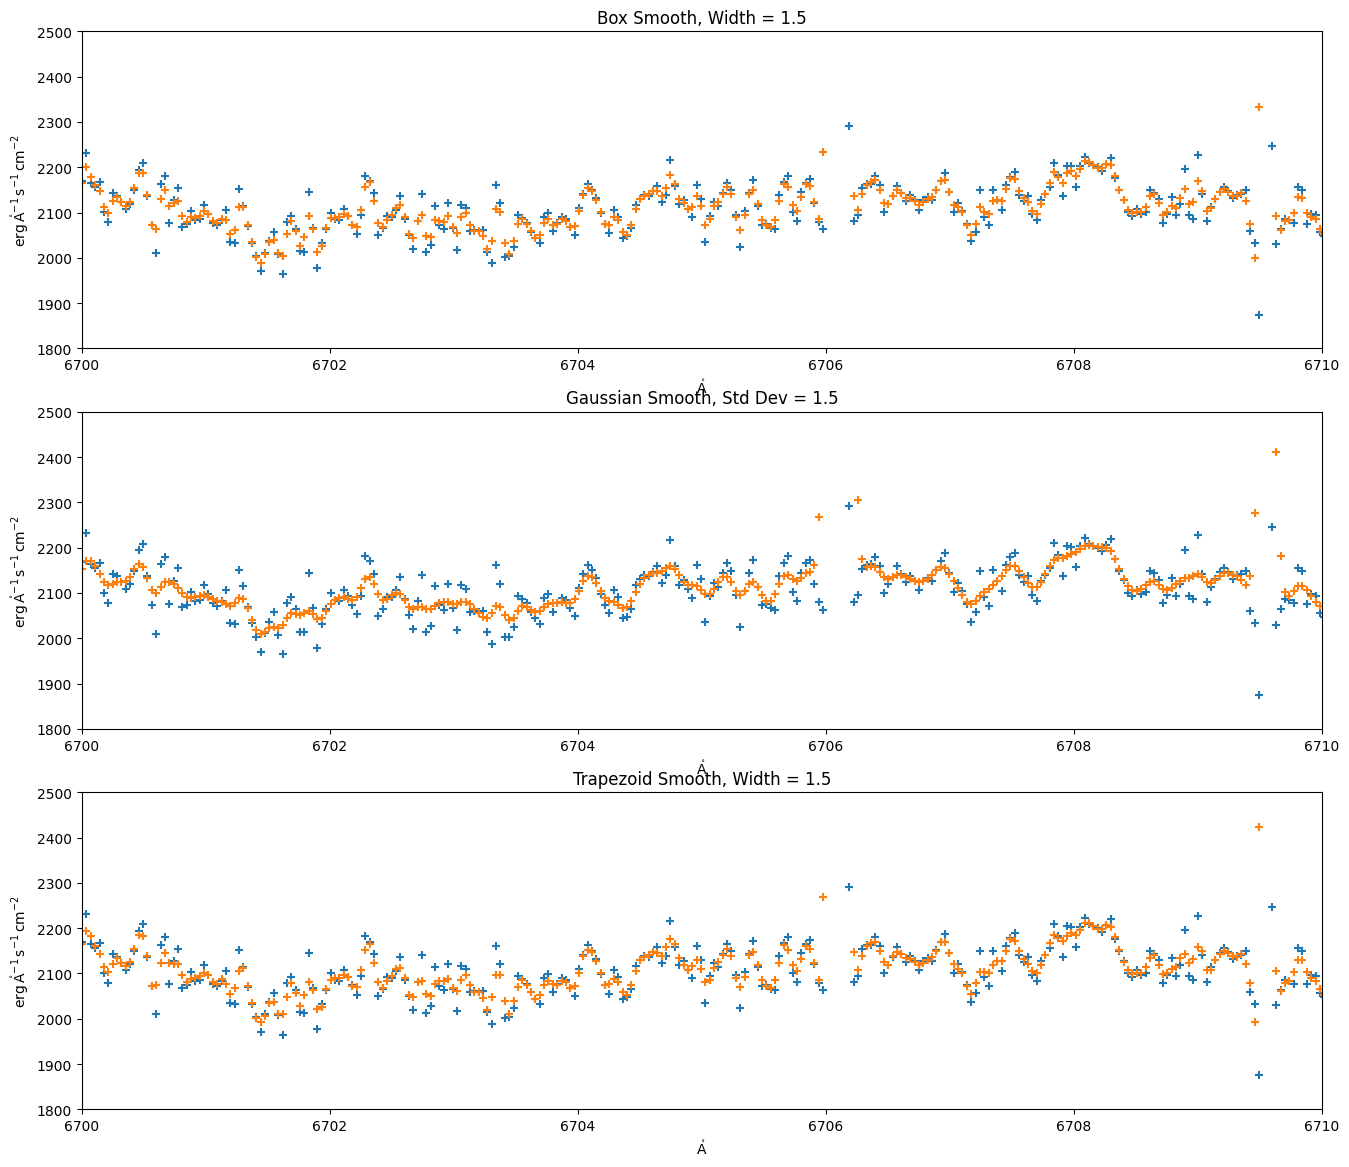

In [22]:
width = 1.5

spec1_bsmooth = box_smooth(spec1[0],width=width)
spec1_gsmooth = gaussian_smooth(spec1[0],stddev=width)
spec1_tsmooth = trapezoid_smooth(spec1[0],width=width)


fig, ax = plt.subplots(3,figsize=(16,14))
ax[0].scatter(spec1[0].spectral_axis,spec1[0].flux, marker='+')
ax[1].scatter(spec1[0].spectral_axis,spec1[0].flux, marker='+')
ax[2].scatter(spec1[0].spectral_axis,spec1[0].flux, marker='+')

ax[0].scatter(spec1_bsmooth.spectral_axis,spec1_bsmooth.flux, marker='+',alpha=1)
ax[1].scatter(spec1_gsmooth.spectral_axis,spec1_gsmooth.flux, marker='+',alpha=1)
ax[2].scatter(spec1_tsmooth.spectral_axis,spec1_tsmooth.flux, marker='+',alpha=1)

ax[0].set_title('Box Smooth, Width = {}'.format(width))
ax[1].set_title('Gaussian Smooth, Std Dev = {}'.format(width))
ax[2].set_title('Trapezoid Smooth, Width = {}'.format(width))

for axis in ax:
    axis.set_xlim(6700,6710)
    axis.set_ylim(1800,2500)

print('Smoothed Spectrum Shapes')
print('------------------------')
print('Original:  ',spec1[0].shape)
print('Box:       ',spec1_bsmooth.shape)
print('Gaussian:  ',spec1_gsmooth.shape)
print('Trapezoid: ',spec1_tsmooth.shape)

Smoothed Spectrum Shapes
------------------------
Original:   (49337,)
Box:        (49337,)
Gaussian:   (49337,)
Trapezoid:  (49337,)


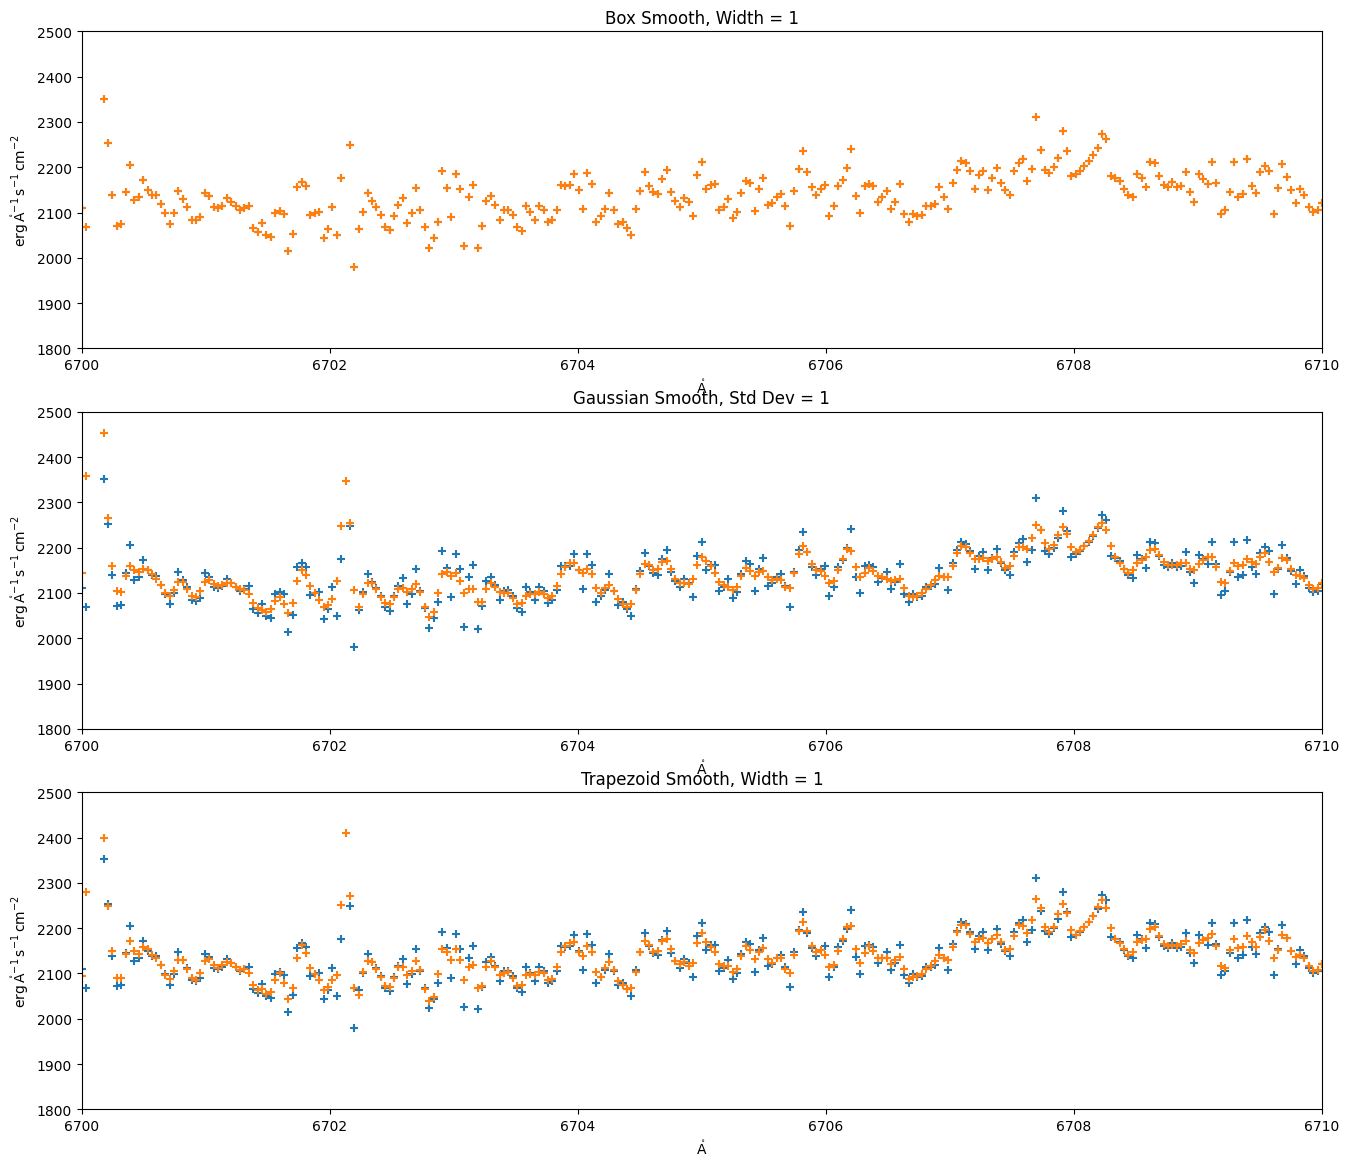

In [23]:
width = 1

spec2_bsmooth = box_smooth(spec2[0],width=width)
spec2_gsmooth = gaussian_smooth(spec2[0],stddev=width)
spec2_tsmooth = trapezoid_smooth(spec2[0],width=width)


fig, ax = plt.subplots(3,figsize=(16,14))
ax[0].scatter(spec2[0].spectral_axis,spec2[0].flux, marker='+')
ax[1].scatter(spec2[0].spectral_axis,spec2[0].flux, marker='+')
ax[2].scatter(spec2[0].spectral_axis,spec2[0].flux, marker='+')

ax[0].scatter(spec2_bsmooth.spectral_axis,spec2_bsmooth.flux, marker='+',alpha=1)
ax[1].scatter(spec2_gsmooth.spectral_axis,spec2_gsmooth.flux, marker='+',alpha=1)
ax[2].scatter(spec2_tsmooth.spectral_axis,spec2_tsmooth.flux, marker='+',alpha=1)

ax[0].set_title('Box Smooth, Width = {}'.format(width))
ax[1].set_title('Gaussian Smooth, Std Dev = {}'.format(width))
ax[2].set_title('Trapezoid Smooth, Width = {}'.format(width))

for axis in ax:
    axis.set_xlim(6700,6710)
    axis.set_ylim(1800,2500)

print('Smoothed Spectrum Shapes')
print('------------------------')
print('Original:  ',spec2[0].shape)
print('Box:       ',spec2_bsmooth.shape)
print('Gaussian:  ',spec2_gsmooth.shape)
print('Trapezoid: ',spec2_tsmooth.shape)

In [24]:
spec3 = (spec1_resampled + spec2[0])/2

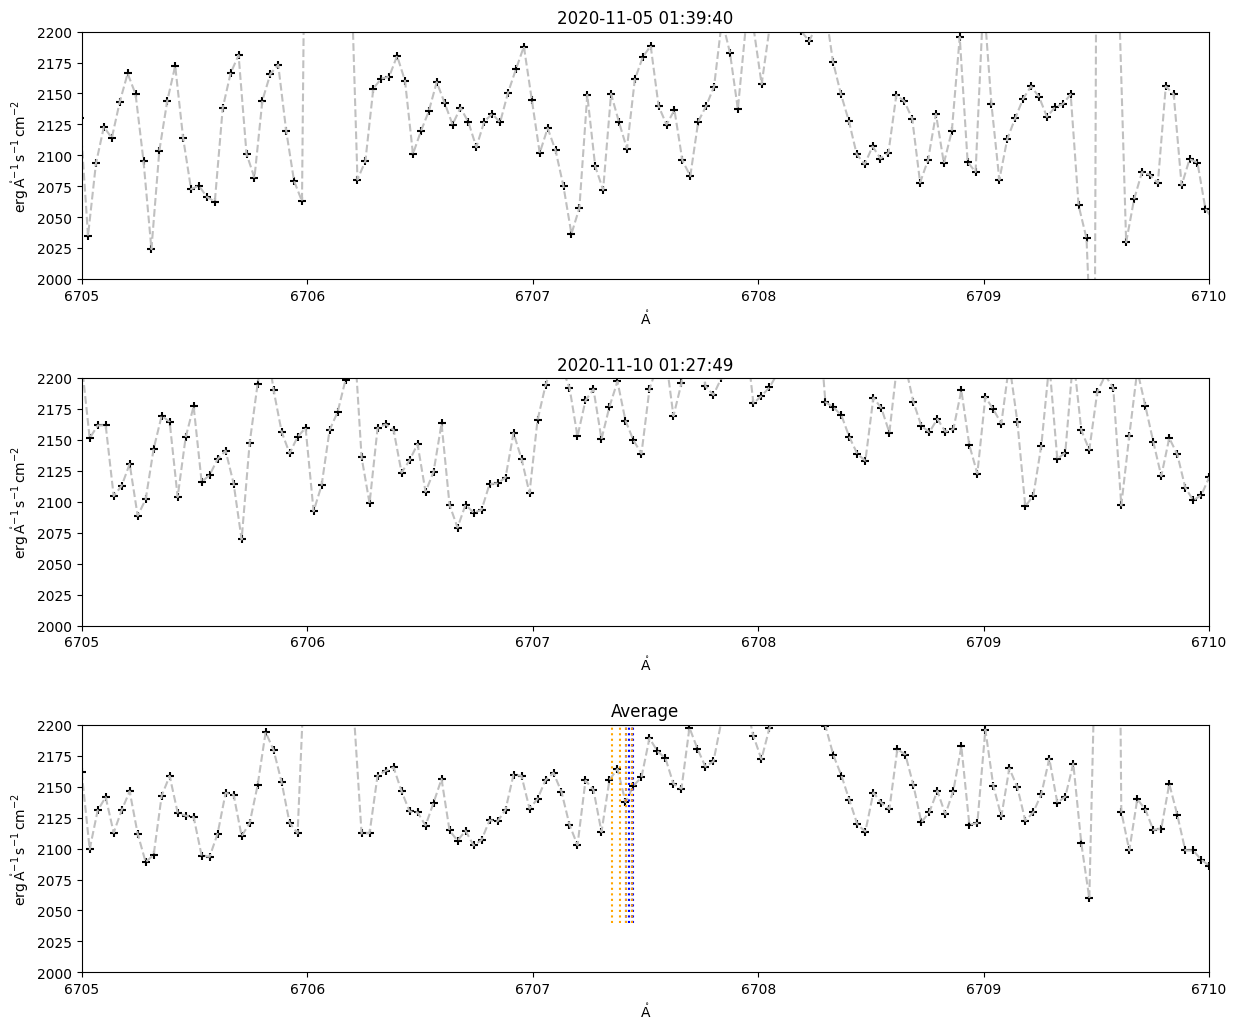

In [25]:
#Spec1 = 2020-11-05 01:39:40
#Spec2 = 2020-11-10 01:27:49


fig, ax = plt.subplots(3,figsize=(12,10))
fig.tight_layout()
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)


ax[0].set_title('2020-11-05 01:39:40')
ax[0].scatter(spec1[0].spectral_axis,spec1[0].flux, marker='+',color='black')
ax[0].plot(spec1[0].spectral_axis,spec1[0].flux, linestyle='dashed',color='silver')

ax[1].set_title('2020-11-10 01:27:49')
ax[1].scatter(spec2[0].spectral_axis,spec2[0].flux, marker='+',color='black')
ax[1].plot(spec2[0].spectral_axis,spec2[0].flux, linestyle='dashed',color='silver')

ax[2].set_title('Average')
ax[2].scatter(spec3.spectral_axis,spec3.flux, marker='+',color='black')
ax[2].plot(spec3.spectral_axis,spec3.flux, linestyle='dashed',color='silver')

for i in range(len(ax)):
    ax[i].set_xlim(6705,6710)
    ax[i].set_ylim(2000,2200)


for i in range(len(pos1)):
    
    ax[2].plot(pos1[i]*np.ones(100)*u.AA,np.linspace(2040,4000,100),linestyle='dotted',color='blue',alpha=1)
    ax[2].plot(pos2[i]*np.ones(100)*u.AA,np.linspace(2040,4000,100),linestyle='dotted',color='orange',alpha=1)


plt.savefig('FBS0022-021SpectraAvg.pdf',bbox_inches='tight')

In [26]:
#spec3.write('fits/FBS0022-021-average.fits')

(3000.0, 8000.0)

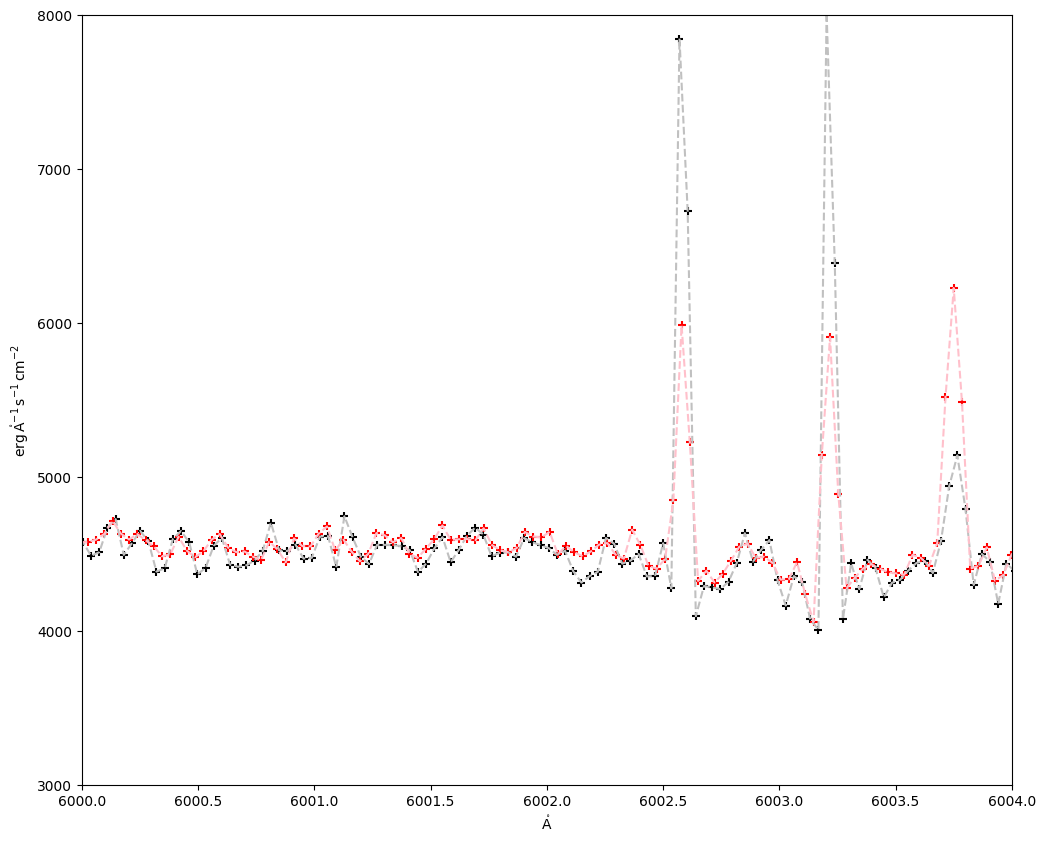

In [27]:
fig, ax = plt.subplots(1,figsize=(12,10))

ax.scatter(spec1[0].spectral_axis,spec1[0].flux, marker='+',color='black')
ax.plot(spec1[0].spectral_axis,spec1[0].flux, linestyle='dashed',color='silver')


ax.scatter(spec3.spectral_axis,spec3.flux, marker='+',color='red')
ax.plot(spec3.spectral_axis,spec3.flux, linestyle='dashed',color='pink')

ax.set_xlim(6000,6004)
ax.set_ylim(3000,8000)